In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import seaborn as sns


Using TensorFlow backend.


## Cargamos el df y hacemos un get_dummies 

In [2]:
coins4L = pickle.load(open('./Output/data/coins_97970_4labels.pkl',"rb"))

In [3]:
coins4L.head()
coins4L['image'].iloc[0].shape

(70, 70, 3)

In [4]:
coins4dumm = pd.get_dummies(coins4L['label'])
coins4dumm['gt'] = coins4dumm.apply(lambda x: pd.Series([x.values]), axis=1)
coins_4labels=coins4L.join(coins4dumm)


In [14]:
coins_4labels = coins_4labels.reset_index()
coins_4labels.head()

,index,image,label,1e,2e,au,cu,gt
0,0,"[[[0.10588235294117647, 0.3176470588235294, 0....",au,0,0,1,0,"[0, 0, 1, 0]"
1,0,"[[[0.10588235294117647, 0.3176470588235294, 0....",au,0,0,1,0,"[0, 0, 1, 0]"
2,0,"[[[0.10588235294117647, 0.3176470588235294, 0....",au,0,0,1,0,"[0, 0, 1, 0]"
3,0,"[[[0.10588235294117647, 0.3176470588235294, 0....",au,0,0,1,0,"[0, 0, 1, 0]"
4,0,"[[[0.10588235294117647, 0.3176470588235294, 0....",au,0,0,1,0,"[0, 0, 1, 0]"


In [6]:
coins_4labels['image'].iloc[0].shape

(70, 70, 3)

#### guardamos nuestro df

In [7]:
coins_4labels.to_pickle('./Output/data/coins_4labels_dummies.pkl')

## Empezamos entrenamiento con df solo con 4 labels 

In [8]:
coins_4labels = pickle.load(open('./Output/data/coins_dum_4labels.pkl',"rb"))

In [9]:
coins_4labels.head()

,image,label,1e,2e,au,cu,gt
0,"[[[27, 81, 110], [94, 165, 195], [30, 85, 117]...",au,0,0,1,0,"[0, 0, 1, 0]"
1,"[[[227, 229, 229], [224, 226, 226], [214, 216,...",au,0,0,1,0,"[0, 0, 1, 0]"
2,"[[[58, 74, 97], [32, 47, 71], [28, 44, 67], [5...",au,0,0,1,0,"[0, 0, 1, 0]"
3,"[[[60, 92, 127], [44, 75, 108], [65, 93, 123],...",au,0,0,1,0,"[0, 0, 1, 0]"
4,"[[[63, 71, 126], [53, 65, 121], [61, 76, 136],...",au,0,0,1,0,"[0, 0, 1, 0]"


In [10]:
img_rows, img_cols, img_channels = 70, 70, 3

In [11]:
X = np.stack(coins_4labels['image'])/255.0
y = np.stack(coins_4labels['gt'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
input_shape=(img_rows, img_cols, img_channels)
num_classes=4

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(84656, 70, 70, 3) (21164, 70, 70, 3) (84656, 4) (21164, 4)


In [28]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adadelta',
              metrics=['accuracy'])

In [29]:
batch_size = 50
epochs = 5

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 84656 samples, validate on 21164 samples
Epoch 1/5
84656/84656 [==============================] - 1160s 14ms/step - loss: 0.2619 - accuracy: 0.9060 - val_loss: 0.0403 - val_accuracy: 0.9883
Epoch 2/5
84656/84656 [==============================] - 1254s 15ms/step - loss: 0.0664 - accuracy: 0.9773 - val_loss: 0.0261 - val_accuracy: 0.9909
Epoch 3/5
84656/84656 [==============================] - 874s 10ms/step - loss: 0.0422 - accuracy: 0.9859 - val_loss: 0.0210 - val_accuracy: 0.9953
Epoch 4/5
84656/84656 [==============================] - 765s 9ms/step - loss: 0.0306 - accuracy: 0.9894 - val_loss: 0.0065 - val_accuracy: 0.9978
Epoch 5/5
84656/84656 [==============================] - 911s 11ms/step - loss: 0.0254 - accuracy: 0.9917 - val_loss: 0.0092 - val_accuracy: 0.9966


In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.009195182946770542
Test accuracy: 0.9965980052947998


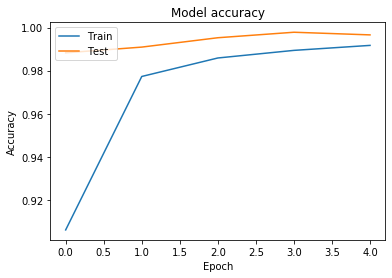

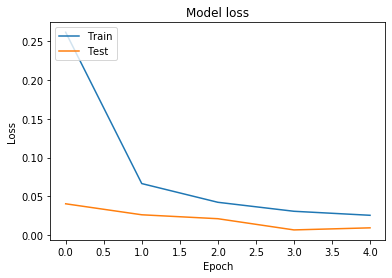

In [33]:

%matplotlib inline
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

[2 2 2 ... 3 3 2]
[2 2 2 ... 3 3 2]


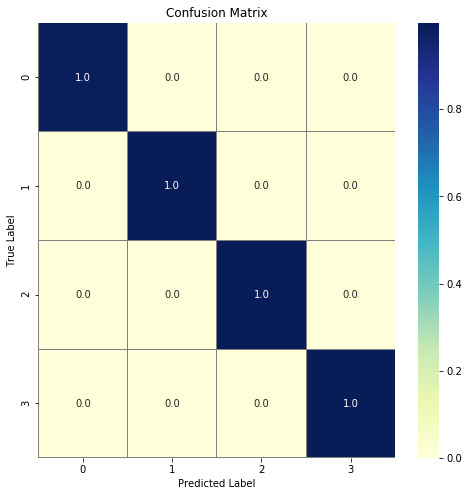

In [34]:
# Confusion Matrix 
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
%matplotlib inline
from PIL import Image
img = X_test[31].astype('float32')
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
print("Probs -> 1€:{0:.5f} 2€:{1:.5f} AU:{2:.5f} CU:{3:.5f}".format(pred[0],pred[1],pred[2],pred[3]))
print(np.expand_dims(img,axis=0).shape)

[3.2821315e-20 8.3429721e-12 1.0000000e+00 2.5436694e-10]
Probs -> 1€:0.00000 2€:0.00000 AU:1.00000 CU:0.00000
(1, 70, 70, 3)


## Guardar el modelo

In [56]:
moment=time.localtime()
name='Model_{}_{}-{}-{}.h5'.format(model.history.history["val_accuracy"][-1],moment[2],moment[3],moment[4])
model.save(name)

In [57]:
model_json = model.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(name)

# Predicciones de imagenes nuevas

In [50]:
from src.predict import whoIam

    

transforming image from new_images/50c_1.jpg
transformed img shape:  (1, 70, 70, 3)
predicction:  [2.4803531e-11 1.4037327e-01 8.5962653e-01 1.9343852e-07]
(1, 226, 223, 3)


'Probs -> 1€:0.00000 2€:0.14037 AU:0.85963 CU:0.00000'

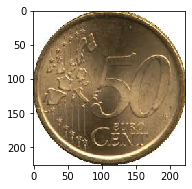

In [52]:
path1 = 'new_images/50c_1.jpg'
whoIam(path1,model)

transforming image from new_images/2c1.jpg
transformed img shape:  (1, 70, 70, 3)
predicction:  [1.6774860e-21 9.9999964e-01 9.2938226e-09 3.1927112e-07]
(1, 1136, 1085, 3)


'Probs -> 1€:0.00000 2€:1.00000 AU:0.00000 CU:0.00000'

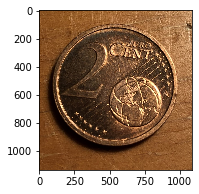

In [53]:
path2 = 'new_images/2c1.jpg'
whoIam(path2,model)

transforming image from new_images/1c2.jpg
transformed img shape:  (1, 70, 70, 3)
predicction:  [1.7071169e-07 1.1490580e-05 5.7942923e-03 9.9419409e-01]
(1, 878, 906, 3)


'Probs -> 1€:0.00000 2€:0.00001 AU:0.00579 CU:0.99419'

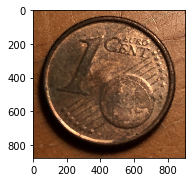

In [54]:
path3 = 'new_images/1c2.jpg'
whoIam(path3,model)


transforming image from new_images/20c2.jpg
transformed img shape:  (1, 70, 70, 3)
predicction:  [5.3838596e-12 4.3796740e-06 9.9990940e-01 8.6146698e-05]
(1, 1107, 1173, 3)


'Probs -> 1€:0.00000 2€:0.00000 AU:0.99991 CU:0.00009'

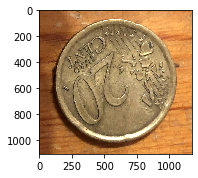

In [55]:
path4 = 'new_images/20c2.jpg'
whoIam(path4,model)

transforming image from new_images/2e2.jpg
transformed img shape:  (1, 70, 70, 3)
predicction:  [9.1511428e-28 7.5924404e-02 9.2407566e-01 3.2608549e-10]
(1, 1020, 1060, 3)


'Probs -> 1€:0.00000 2€:0.07592 AU:0.92408 CU:0.00000'

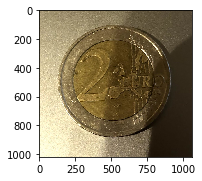

In [59]:
path4 = 'new_images/2e2.jpg'
whoIam(path4,model)

transforming image from new_images/1e1.jpg
transformed img shape:  (1, 70, 70, 3)
predicction:  [9.8759371e-01 1.7895610e-18 1.2403542e-02 2.6682731e-06]
(1, 930, 990, 3)


'Probs -> 1€:0.98759 2€:0.00000 AU:0.01240 CU:0.00000'

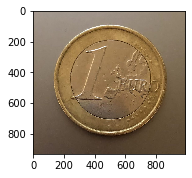

In [60]:
path4 = 'new_images/1e1.jpg'
whoIam(path4,model)

transforming image from new_images/2e1.jpg
transformed img shape:  (1, 70, 70, 3)
predicction:  [2.2049594e-21 9.9993682e-01 6.3200139e-05 5.8518385e-11]
(1, 991, 1005, 3)


'Probs -> 1€:0.00000 2€:0.99994 AU:0.00006 CU:0.00000'

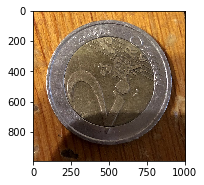

In [61]:
path4 = 'new_images/2e1.jpg'
whoIam(path4,model)